In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress # Added for slope calculation


df_combined = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/combined_dataset.csv')
I_0 = df_combined['red_intensity'].max()
def calculate_od_from_red_intensity(red_intensity, I0 = I_0):
    if pd.isna(red_intensity):
        return np.nan
    # Replace with your actual formula. For example:
    if red_intensity <= 0: return np.nan
    return -np.log10(red_intensity / I0)


In [5]:

df_combined['OD'] = df_combined['red_intensity'].apply(calculate_od_from_red_intensity)


In [9]:
HF_COLUMNS = ['temperature (C)', 'pH', 'dO', 'light_intensity (lumens)']
# AGG_FUNCTIONS = ['mean', 'std', 'min', 'max', 'median']

def calculate_slope(series):
    """Calculates the slope of the linear regression of a series against its index count."""
    series_cleaned = series.dropna() # Drop NaNs for regression
    if len(series_cleaned) < 2: # Need at least 2 points for a line
        return np.nan
    
    # Use a simple sequence for x-values (representing equidistant time progression within the chunk)
    x_values = np.arange(len(series_cleaned))
    y_values = series_cleaned.values
    
    try:
        # slope, intercept, r_value, p_value, std_err
        slope, _, _, _, _ = linregress(x_values, y_values)
        return slope
    except Exception: # Catch any error during regression
        return np.nan
calculate_slope.__name__ = 'slope' # Assign name for easier column naming later

def calculate_first_last_diff(series):
    """Calculates the difference between the last and first valid (non-NaN) observation in a series."""
    series_cleaned = series.dropna()
    if len(series_cleaned) < 2: # Need at least two points to have a first and a last to diff
        return np.nan
    
    first_val = series_cleaned.iloc[0]
    last_val = series_cleaned.iloc[-1]
    return last_val - first_val
calculate_first_last_diff.__name__ = 'first_last_diff'

# Define aggregation functions, including custom ones
AGG_FUNCTIONS = ['mean', 'std', 'min', 'max', 'median', calculate_slope, calculate_first_last_diff]


def process_sensor_data(df_input):
    # Identify rows where OD was actually measured (not NaN)
    od_measurements_df = df_input[df_input['OD'].notna()].copy()

    if len(od_measurements_df) < 2:
        print("Not enough OD measurements (<2) to calculate delta_OD and features. Returning empty DataFrame.")
        return pd.DataFrame()

    # Get the sorted timestamps of OD measurements
    od_timestamps = od_measurements_df.index.tolist()

    processed_data_list = []

    # Iterate through OD measurements to define chunks and calculate features
    # Start from the second OD measurement to be able to calculate delta_OD
    for i in range(1, len(od_timestamps)):
        current_od_time = od_timestamps[i]
        previous_od_time = od_timestamps[i-1]

        current_od_value = od_measurements_df.loc[current_od_time, 'OD']
        previous_od_value = od_measurements_df.loc[previous_od_time, 'OD']
        delta_od = current_od_value - previous_od_value

        # Define the data chunk for summary statistics:
        # All rows in the *original* df_input strictly after previous_od_time
        # and up to and including current_od_time.
        chunk_for_summary = df_input.loc[
            (df_input.index > previous_od_time) & (df_input.index <= current_od_time)
        ]

        current_row_data = {
            'OD': current_od_value,
            'delta_OD': delta_od
        }

        if not chunk_for_summary.empty:
            summary_stats = chunk_for_summary[HF_COLUMNS].agg(AGG_FUNCTIONS)
            # Flatten the MultiIndex columns from agg (e.g., ('pH', 'mean') -> 'pH_mean')
            for col_tuple in summary_stats.columns: # This is if AGG_FUNCTIONS is a list of lists/dicts
                # If AGG_FUNCTIONS is a simple list, summary_stats.stack() is better
                pass # Will use stack below

            # Using stack() for robust flattening if AGG_FUNCTIONS is a simple list
            for (sensor, stat), value in summary_stats.stack().items():
                flat_col_name = f"{sensor}_{stat}"
                current_row_data[flat_col_name] = value
        else:
            # If chunk is empty, fill summary stats with NaN
            for sensor in HF_COLUMNS:
                for stat in AGG_FUNCTIONS:
                    current_row_data[f"{sensor}_{stat}"] = np.nan
        
        # Store the data for this OD point, using its timestamp as the intended index
        processed_data_list.append(pd.Series(current_row_data, name=current_od_time))

    if not processed_data_list:
        print("No data processed (e.g. only one OD measurement). Returning empty DataFrame.")
        return pd.DataFrame()

    final_df = pd.DataFrame(processed_data_list)
    return final_df



In [12]:
summary_statistics_df = process_sensor_data(df_combined)

<Figure size 1200x1000 with 0 Axes>

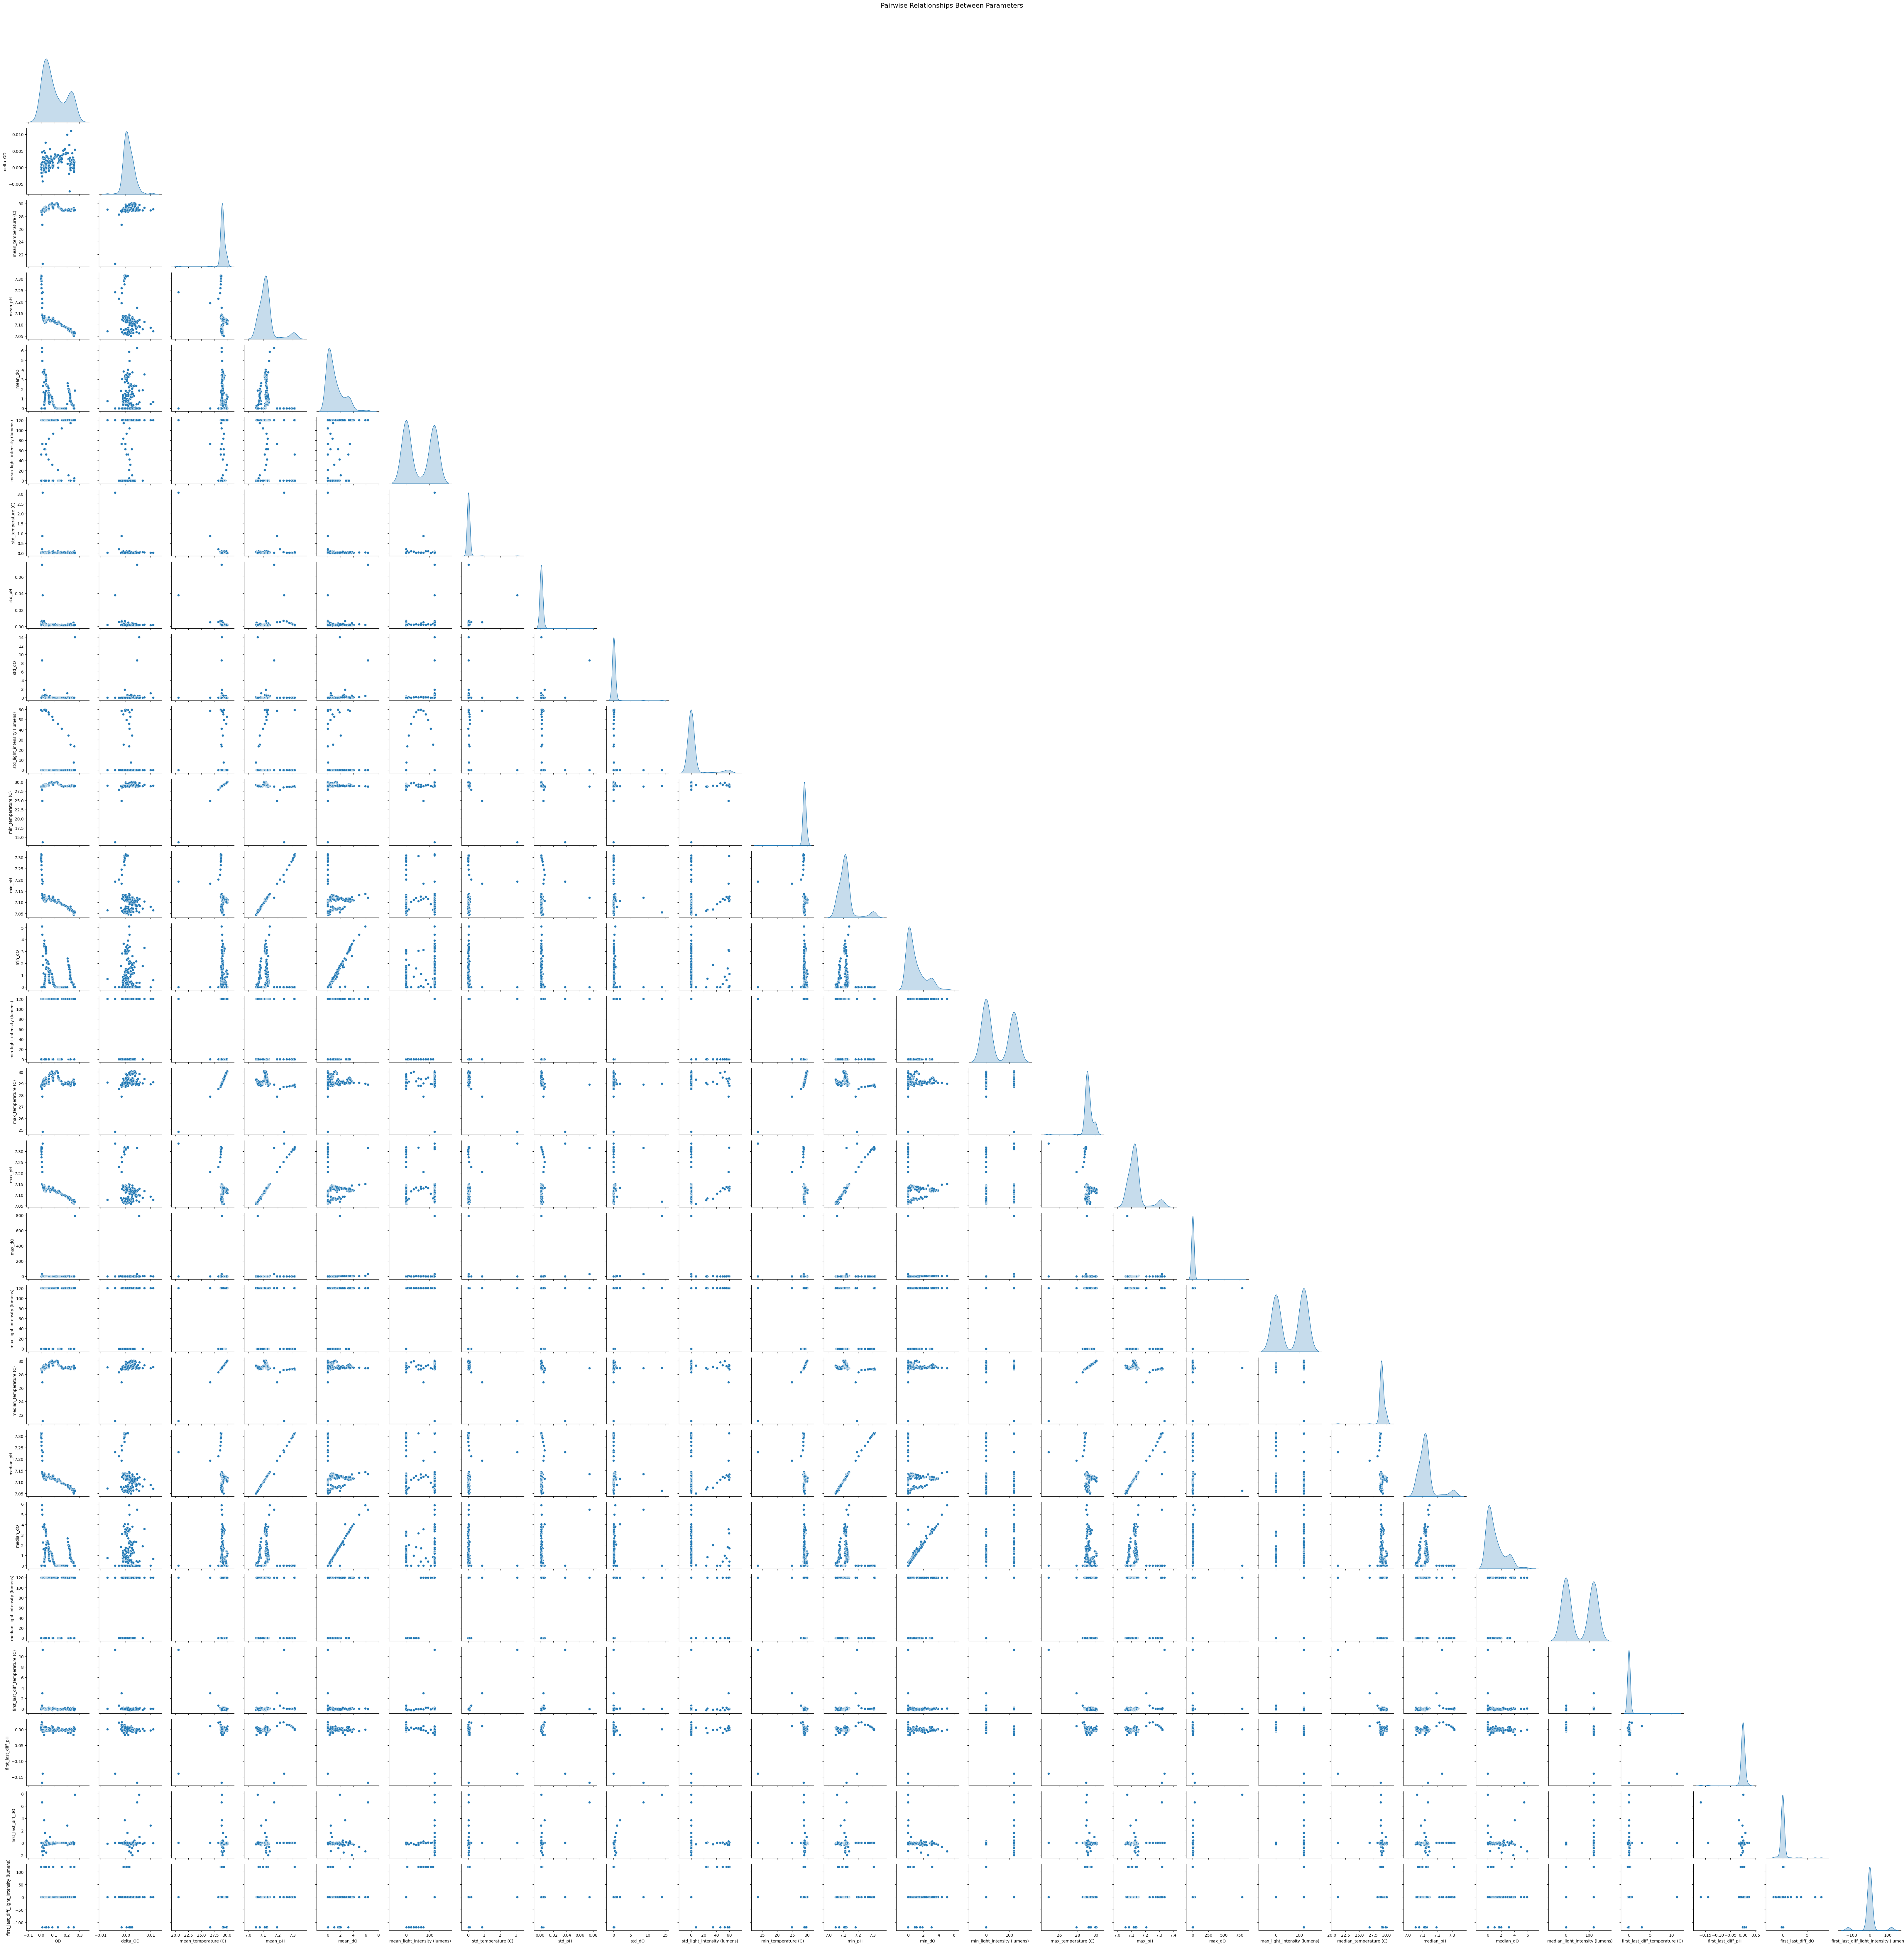

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.pairplot(summary_statistics_df, diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Between Parameters', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
summary_statistics_df.to_csv('cyano_culture_datasets/04-15-2025 culture/combined_dataset_summary_statistics.csv')

# So we'll wanna do some sort of normalization probably

In [ ]:
# For now let's skip normalization
# # normalize the data using standardscaler
# from sklearn.preprocessing import StandardScaler
# # scaler = StandardScaler()
# df_combined.iloc[:, 3:] = scaler.fit_transform(df_combined.iloc[:, 1:])
# df_combined